In [1]:
import optuna
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, confusion_matrix, roc_curve, auc

C:\Users\gonca\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Model Training

The purpose of this notebook is to build and evaluate an XGBoost model for our predictions. It incorporates thorough preprocessing, feature evaluation, hyperparameter tuning, and model validation to ensure robust performance and interpretable insights.

In [2]:
# Load the teams data
dataset = pd.read_csv('../../cleaned_data/dataset.csv')

label = 'PlayoffNextSeason'
features = [
    'Rank', 'PlayoffProgScore', 'FTA', 'DREB', 'AST/TO', 'REB%', 'CumulativePlayoffProgScore', 'AvgPIE_NextYearPlayers', 'Performance_NextYearCoach'
]

# Prepare feature and label data
X = dataset[features]
y = dataset[label]

A heatmap of the correlation matrix is plotted to visualize linear relationships between features and their potential multicollinearity. High correlations among features might indicate redundancy.

The MI scores measure the dependency between each feature and the target variable. Higher scores suggest a stronger predictive relationship. A bar plot is used to rank features by their MI scores.

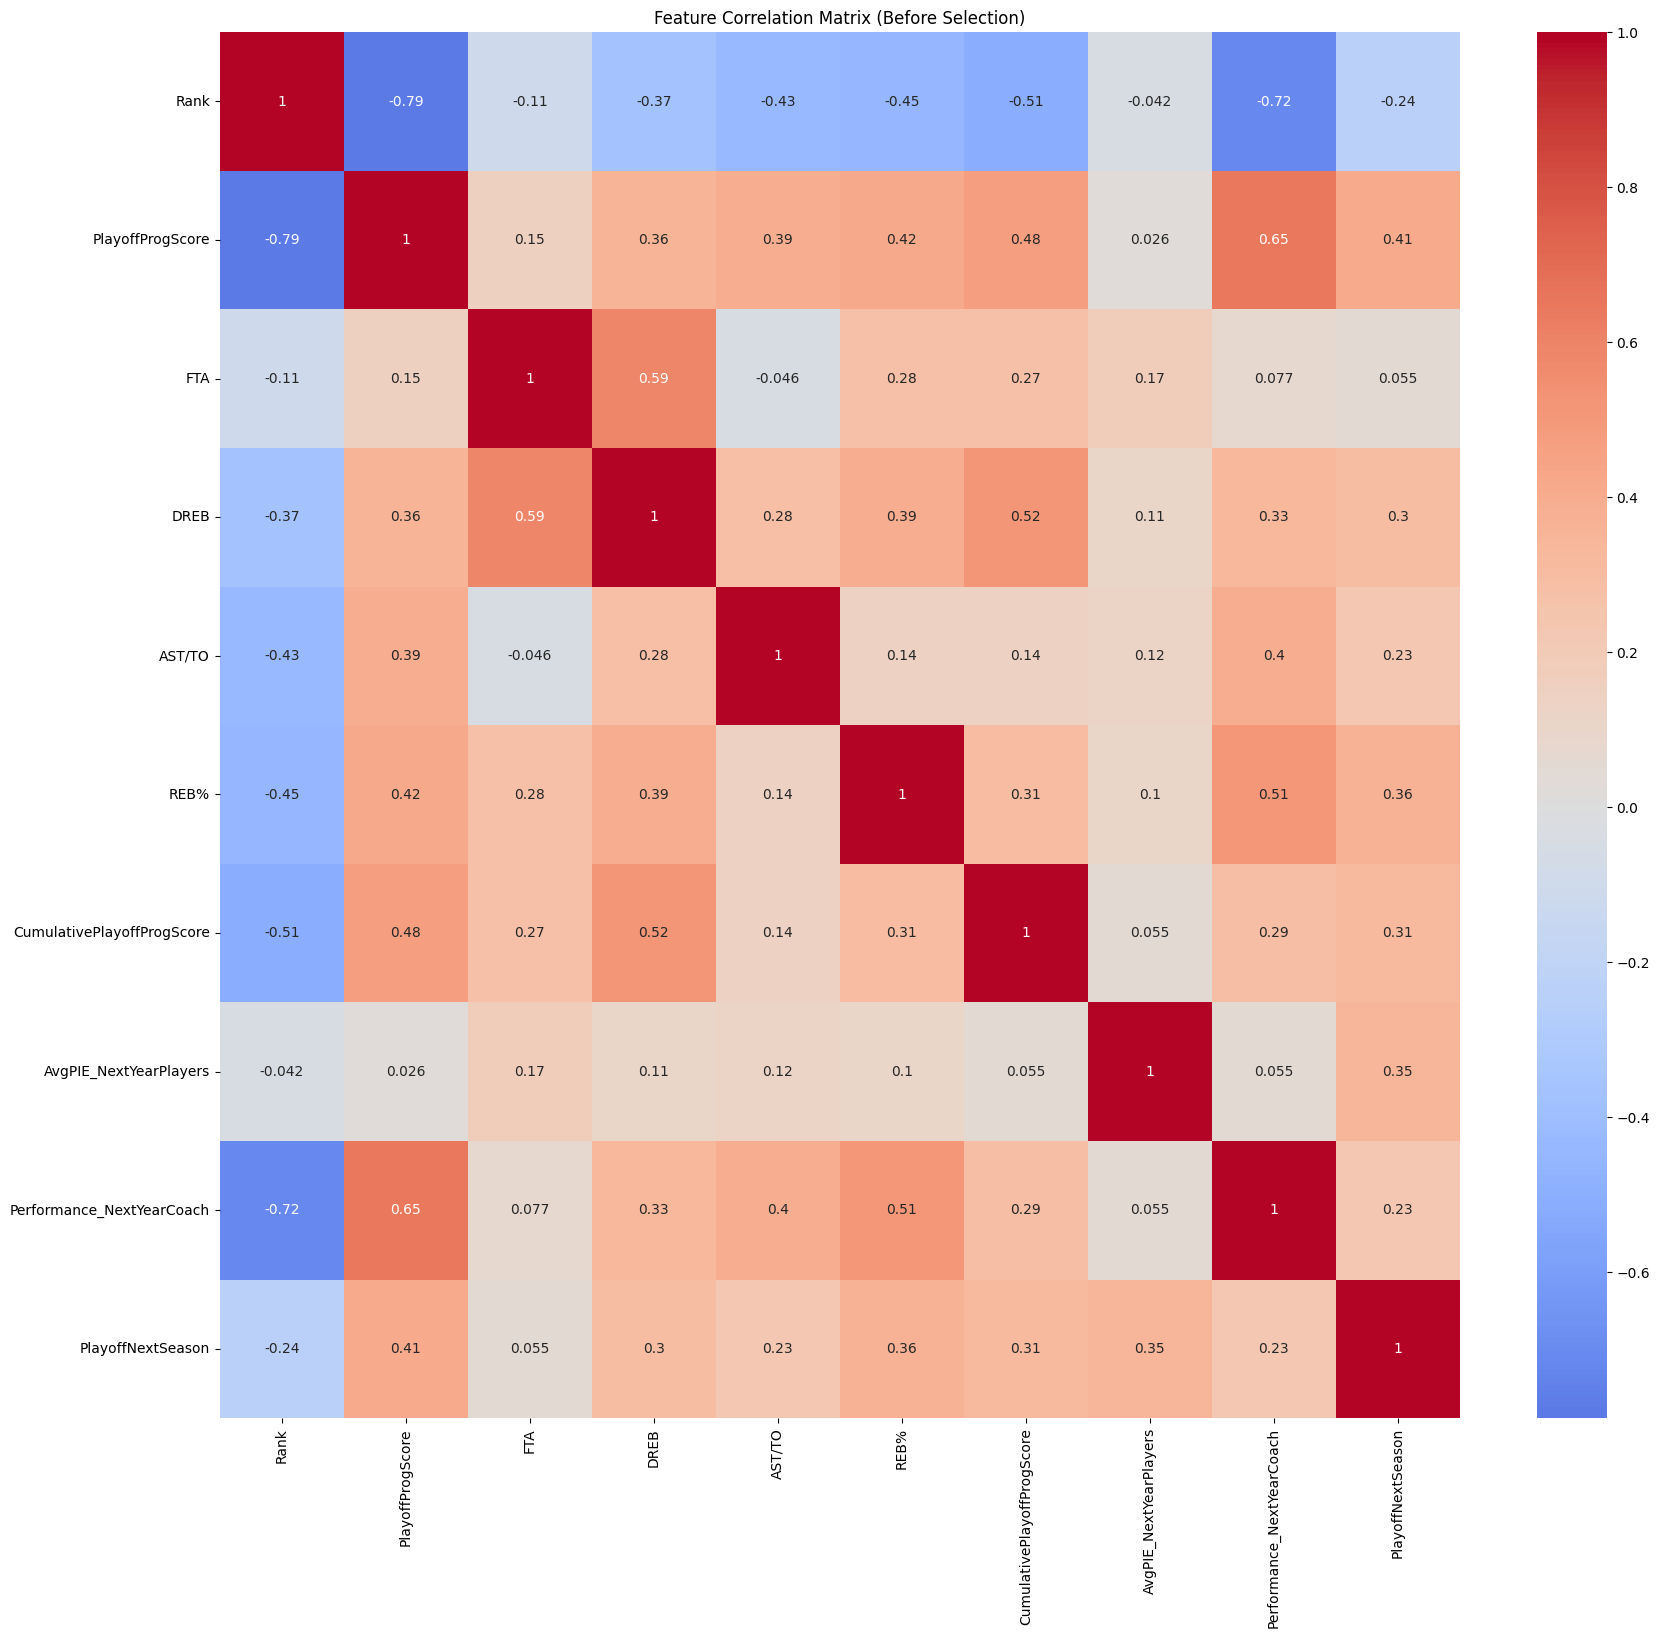

In [3]:
# ============================
# Display Initial Correlation Matrix
# ============================

# Calculate and plot the correlation matrix
correlation_matrix = dataset[features + [label]].corr()
plt.figure(figsize=(20, 18))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix (Before Selection)')
plt.show()

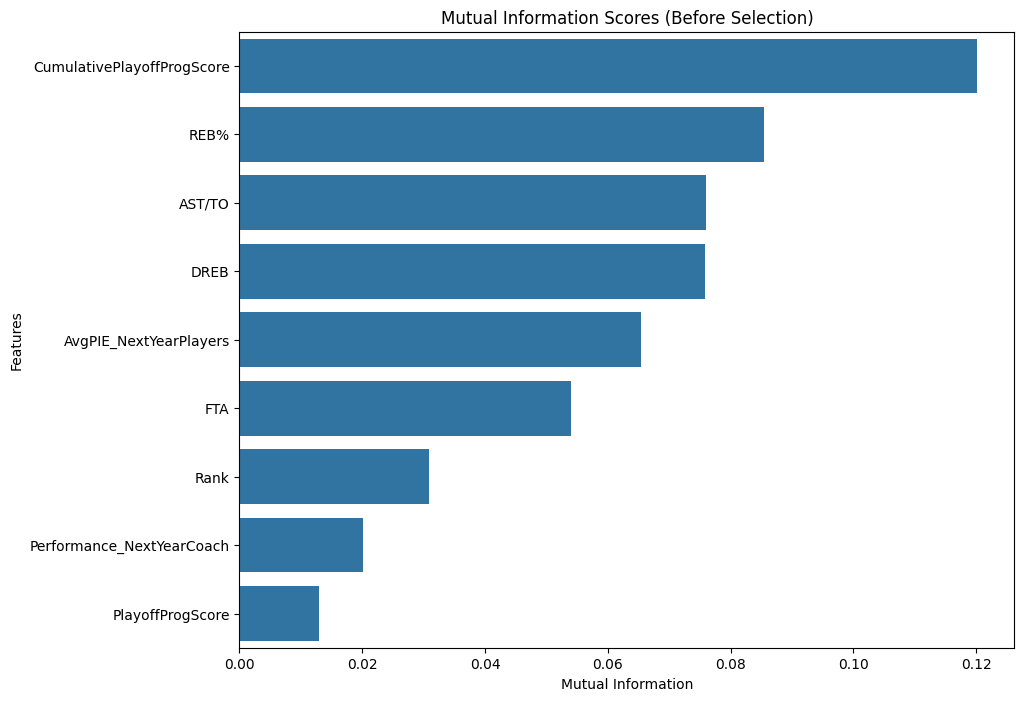

In [4]:
# ============================
# Display Initial Mutual Information Scores
# ============================

# Calculate mutual information
mi_scores = mutual_info_classif(X, y, discrete_features='auto', random_state=42)
mi_scores = pd.Series(mi_scores, index=X.columns, name='MI Scores')
mi_scores = mi_scores.sort_values(ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x=mi_scores.values, y=mi_scores.index)
plt.title('Mutual Information Scores (Before Selection)')
plt.xlabel('Mutual Information')
plt.ylabel('Features')
plt.show()

`create_model` uses Optuna to dynamically generate an XGBoost model based on suggested hyperparameters. XGBoost is a robust gradient-boosting framework known for its efficiency and performance in handling structured data.

The hyperparameters optimized include:

- Learning Rate: Controls the step size in updating weights.
- Number of Estimators: The number of boosting rounds.
- Max Depth: Controls the complexity of the model.
- Subsample and Colsample_bytree: Control the fraction of samples and features used during training, which helps prevent overfitting.
- Regularization Parameters: reg_alpha and reg_lambda reduce overfitting by adding penalties.
- Scale Pos Weight: Balances the impact of classes in case of class imbalance.

In [9]:
# ============================
# Define the XGBoost model
# ============================

def create_model(trial):
    return XGBClassifier(
        random_state=42,
        eval_metric='logloss',
        learning_rate=trial.suggest_float('learning_rate', 0.01, 0.3),
        n_estimators=trial.suggest_int('n_estimators', 50, 500),
        max_depth=trial.suggest_int('max_depth', 3, 10),
        min_child_weight=trial.suggest_int('min_child_weight', 1, 10),
        subsample=trial.suggest_float('subsample', 0.5, 1.0),
        colsample_bytree=trial.suggest_float('colsample_bytree', 0.5, 1.0),
        gamma=trial.suggest_float('gamma', 0, 5),
        reg_alpha=trial.suggest_float('reg_alpha', 0, 1),
        reg_lambda=trial.suggest_float('reg_lambda', 0, 1),
        scale_pos_weight=trial.suggest_float('scale_pos_weight', 1, 100)
    )

After defining the model, `StratifiedKFold` with K=10 was used to mantain class distribution in each fold. We also defined a custom scorer for specificity, which is the true negative rate. This ensures that the cross-validation process is robust.

In [6]:
# Use StratifiedKFold to maintain class distribution in each fold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Define specificity scorer
def specificity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

specificity_scorer = make_scorer(specificity)

# Define the scoring metrics
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc',
    'specificity': specificity_scorer
}

#### Hyperparameter Tuning

`Optuna` was used in order to find the best hyperparameters for this model. An objective function was created to combine mean accuracy and mean AUC to evaluate the model's performance, and StratifiedKFold cross-validation to do the same.

In [7]:
# ============================
# Hyperparameter Tuning with Optuna
# ============================
def objective(trial):
    model = create_model(trial)
    cv_results = cross_validate(model, X, y, cv=skf, scoring=['accuracy', 'roc_auc'], n_jobs=-1)
    mean_accuracy = np.mean(cv_results['test_accuracy'])
    mean_auc = np.mean(cv_results['test_roc_auc'])

    return 0.6 * mean_accuracy + 0.4 * mean_auc
    
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=1000, n_jobs=-1)

# Use the best hyperparameters to create the final model
best_params = study.best_params
print("Best Hyperparameters:", best_params)
print("Best Value:", study.best_value)

final_model = XGBClassifier(**best_params, random_state=42, eval_metric='logloss')

[I 2024-12-20 21:53:16,019] A new study created in memory with name: no-name-9d3b5a87-258e-4b0c-a7db-b66d22552f2e
C:\Users\gonca\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
1 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\gonca\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File

Best Hyperparameters: {'learning_rate': 0.2548058019131799, 'n_estimators': 72, 'max_depth': 4, 'min_child_weight': 2, 'subsample': 0.7907296009001825, 'colsample_bytree': 0.6792313690568293, 'gamma': 0.3714215215323081, 'reg_alpha': 0.19118663830397054, 'reg_lambda': 0.07241852350735321, 'scale_pos_weight': 33.41130870543981}
Best Value: 0.8485918367346938


#### Results

Finally, the model was evaluated using cross-validation, obtaining important performance metrics and feature importance. The multiple performance metrics were displayed and ROC curves were plotted so the results could be analyzed and improvements could be drawn from that.

,Feature,Average Importance
1,PlayoffProgScore,0.157187
5,REB%,0.131946
3,DREB,0.131277
0,Rank,0.128780
7,AvgPIE_NextYearPlayers,0.106772
2,FTA,0.098307
6,CumulativePlayoffProgScore,0.082933
8,Performance_NextYearCoach,0.081866
4,AST/TO,0.080933


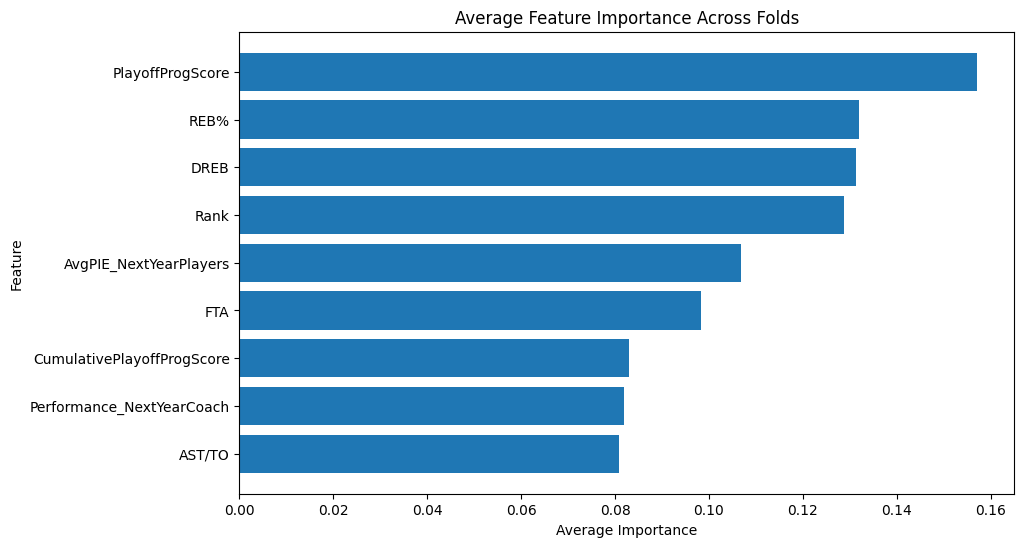

Mean Cross-Validation Accuracy: 0.8376190476190477
Mean Cross-Validation Precision: 0.7883333333333333
Mean Cross-Validation Recall: 0.9571428571428571
Mean Cross-Validation F1 Score: 0.85899069884364
Mean Cross-Validation AUC Score: 0.8650510204081632
Mean Cross-Validation Specificity: 0.7178571428571429


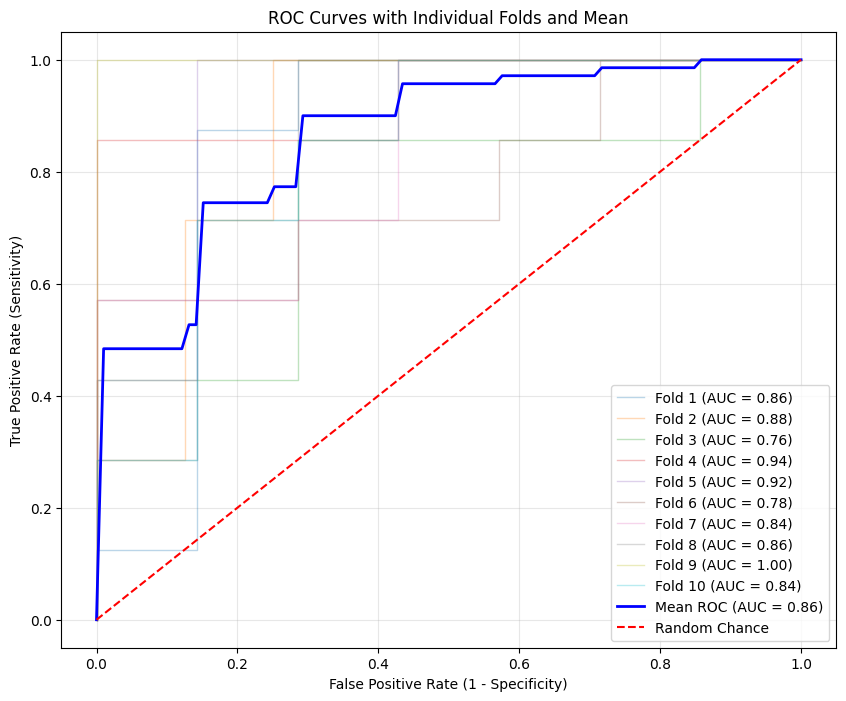

In [8]:
# ============================
# Final Evaluation
# ============================
cv_results = cross_validate(
    final_model, X, y, cv=skf, scoring=scoring, return_estimator=True, n_jobs=-1
)

feature_importances = []
for estimator in cv_results['estimator']:
    feature_importances.append(estimator.feature_importances_)

average_importances = np.mean(feature_importances, axis=0)

feature_names = X.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Average Importance': average_importances
}).sort_values(by='Average Importance', ascending=False)

# Display the feature importance table
display(importance_df)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Average Importance'])
plt.xlabel('Average Importance')
plt.ylabel('Feature')
plt.title('Average Feature Importance Across Folds')
plt.gca().invert_yaxis()
plt.show()

print("Mean Cross-Validation Accuracy:", cv_results['test_accuracy'].mean())
print("Mean Cross-Validation Precision:", cv_results['test_precision'].mean())
print("Mean Cross-Validation Recall:", cv_results['test_recall'].mean())
print("Mean Cross-Validation F1 Score:", cv_results['test_f1'].mean())
print("Mean Cross-Validation AUC Score:", cv_results['test_roc_auc'].mean())
print("Mean Cross-Validation Specificity:", cv_results['test_specificity'].mean())

# ROC Curve Visualization with Individual Folds
plt.figure(figsize=(10, 8))
mean_fpr = np.linspace(0, 1, 100)
tprs = []
aucs = []
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    final_model.fit(X_train, y_train)
    y_proba = final_model.predict_proba(X_test)[:, 1]
    
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label=f'Fold {i+1} (AUC = {roc_auc:.2f})')

# Plot the mean ROC curve
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f})', lw=2)

# Plot the random chance line
plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random Chance')

plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curves with Individual Folds and Mean')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

The `AUC` scores for individual folds range from 0.73 (Fold 3) to 1.00 (Fold 9), indicating variability in model performance across the folds.

Most folds show `AUC` scores above 0.8, indicating good classification ability for most splits.

The `mean AUC` score is 0.87, which suggests the model performs well on average, and is the highest of all models, but a high variability can also be observed.